# Creating Ontology of 311 Park Names -> official park names

This notebook creates a match dictionary between park names in 311 data and in NYC Parks official dataset. 
Using this dictionary we can match each park-related call to specific park or park District

Here I am using [fuzzywuzzy module](https://github.com/seatgeek/fuzzywuzzy)

In [50]:
__author__ = "Philipp Kats"
__date__ = "2015_10_15"

import pandas as pd
import geopandas as gp
import pylab as plt
import os
from fuzzywuzzy import process  ## fuzzy string match in python

# import json
# import numpy as np

# from geopandas.tools import sjoin
# from shapely.geometry import Point

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [51]:
PARQA = os.getenv('PARQA') #basic path

## Getting Data: both 311 Calls names and Park official names to match

In [52]:
def clean(x):
    return x.lower().replace('pool - ','').replace('playground','').strip()

In [53]:
calls = pd.DataFrame(pd.read_csv(PARQA + 'data/311/2015_10_9_311_parks.csv',encoding='utf8'))
                     
callParks = pd.DataFrame(calls[calls.Agency=='DPR']['Park Facility Name'].drop_duplicates())
callParks['cleanName'] = callParks['Park Facility Name'].apply(clean)
print '311_call_names total:', len(callParks['Park Facility Name'])
callParks.head(3)

311_call_names total: 1604


,Park Facility Name,cleanName
0,Ruppert Park,ruppert park
1,Prospect Park,prospect park
2,Tappen Park,tappen park


We will use official park names as a choicelist for each 311_name to choose from

In [54]:
## using geojson produced of OPEN DATA 
parkNames = pd.DataFrame(gp.read_file(PARQA + 'data/parks_computed.geojson')['SIGNNAME'].drop_duplicates().str.lower())

In [55]:
## TODO Should filter other agencies on the earlier stage

ofParks =[unicode(x) for x in parkNames.SIGNNAME.tolist() if type(x)!=float]
print 'Official names total: ', len(ofParks) #this list gonna be our candidates reference
parkNames.head(3)

Official names total:  1789


,SIGNNAME
0,queensbridge park
1,ambrosini field
2,flight 587 memorial park


## Matching 

As Fuzzy works bit slow, lets first match perfect ones with pd.merge function

In [56]:
callParks2 = callParks.merge(parkNames, how='left', left_on = 'cleanName', right_on='SIGNNAME', copy=1)

In [57]:
Unmatched = callParks2[pd.isnull(callParks2.SIGNNAME)]
Matched = callParks2[pd.notnull(callParks2.SIGNNAME)]

print 'Unmatched: ', len(Unmatched)

Unmatched:  1240


In [58]:
## function

def getBest(x):
    global ofParks
    return process.extractOne(x, ofParks)

In [59]:
##################### MATCNING PROCESS
##################### ATTENTION !!!!!!
##################### TAKES 10 MINUTES

Unmatched['match'] = Unmatched['Park Facility Name'].apply(getBest)

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
Unmatched['SIGNNAME'] = Unmatched['match'].apply(lambda x: x[0])
Unmatched['ratio'] = Unmatched['match'].apply(lambda x: x[1])

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Average ratio: 92.6911290323
ratio stD: 5.88336339401


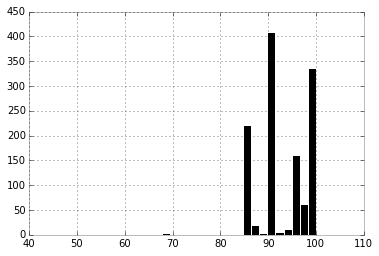

In [61]:
print 'Average ratio:', Unmatched['ratio'].mean()
print 'ratio stD:', Unmatched['ratio'].std()
Unmatched.ratio.hist(color='k', bins=30);

Yet the best option to be sure - check all candidates.

In [62]:
Unmatched[Unmatched.ratio >85].sort_values(by='ratio').head(10)

,Park Facility Name,cleanName,SIGNNAME,match,ratio
553,Reeds Basket Willow's Swamp,reeds basket willow's swamp,reed's basket willow swamp park,"(reed's basket willow swamp park, 86)",86
689,Palmetto Playground,palmetto,pratt playground,"(pratt playground, 86)",86
1311,Gowanus Playground,gowanus,gorman playground,"(gorman playground, 86)",86
108,Kissena Corridor East,kissena corridor east,kissena corridor park,"(kissena corridor park, 86)",86
1574,PS 45 Playground,ps 45,p.s. 155 playground,"(p.s. 155 playground, 86)",86
598,Strong Street Playground,strong street,downing street playground,"(downing street playground, 86)",86
634,Martins Field Playground,martins field,sarsfield playground,"(sarsfield playground, 86)",86
589,Ramirez Playground,ramirez,ampere playground,"(ampere playground, 86)",86
1572,Imagine Playground,imagine,wagner playground,"(wagner playground, 86)",86
976,Recreation Center - St. James,recreation center - st. james,recreation center 54,"(recreation center 54, 87)",87


In [63]:
Matched['ratio'] = 100
JoinedD = pd.concat([Matched, Unmatched[['SIGNNAME','Park Facility Name', 'ratio']]]).sort_values(by='ratio')

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
JoinedD.head()

,Park Facility Name,SIGNNAME,ratio
299,Israel Putnam - PS 44,Luna Park,49
946,Liberty,Albert J. Parham Playground,63
561,Glenwood Houses,Glenwood Playground,66
814,Edenwald Houses,Edenwald Playground,66
797,Windmuller,Mall,67


In [35]:
JoinedD.describe()

,ratio
count,1604.000000
mean,94.355362
std,6.029323
min,49.000000
25%,90.000000
50%,95.000000
75%,100.000000
max,100.000000


In [29]:
JoinedD.to_csv(PARQA + 'data/matched_unmattched2.csv' , encoding='utf8')